In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.gradient
import xarray as xr

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.1


In [2]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

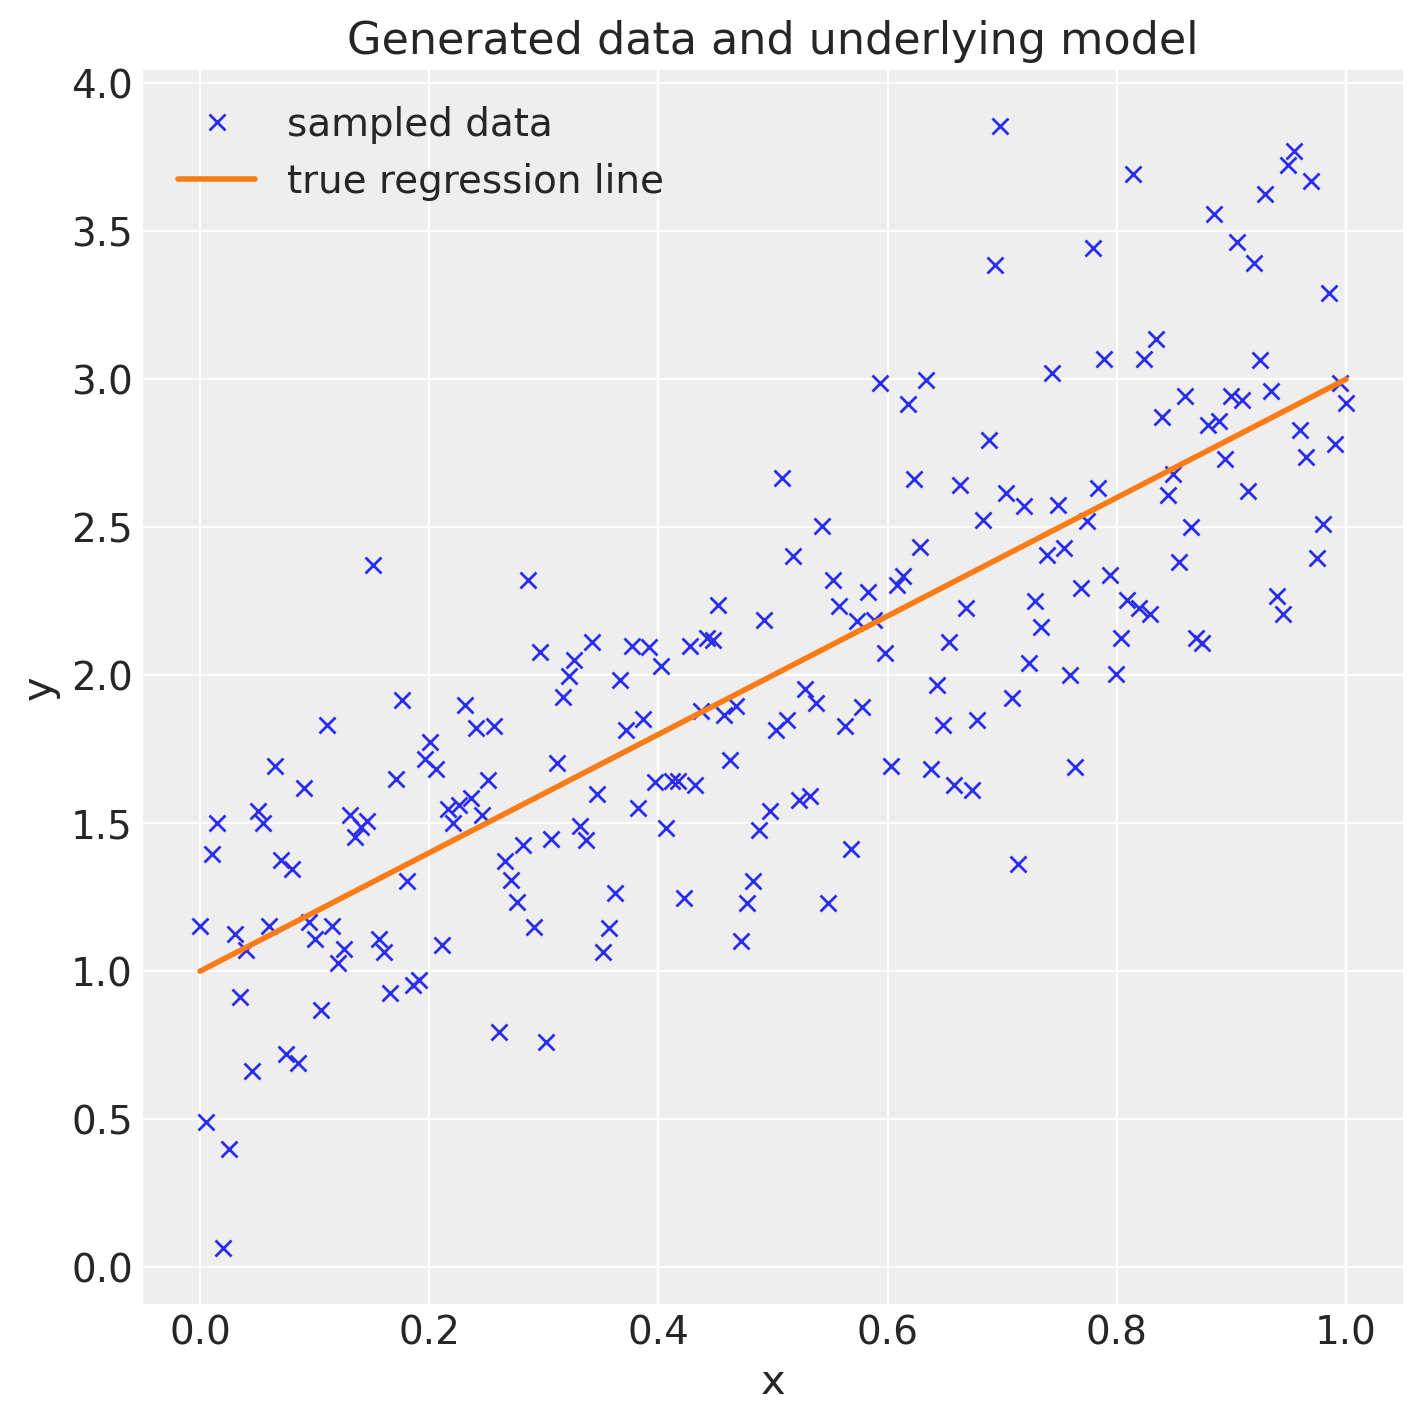

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [5]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.


In [9]:
with model:
    pmap = pm.find_MAP(include_transformed=True)
    hess_op = model.d2logp(model.free_RVs, jacobian=False)
    hess = model.compile_d2logp([model.free_RVs,[sigma, intercept, slope]][1], jacobian=False)

In [18]:
import pytensor
pytensor.gradient.grad(pm.math.det(hess_op), model.free_RVs)

DisconnectedInputError:  
Backtrace when that variable is created:

  File "/Users/xuewc/miniconda3/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/xuewc/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/xuewc/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/xuewc/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/x2/2nnbgrmj3hl3pq2x07gxnt540000gn/T/ipykernel_75515/1313318027.py", line 3, in <module>
    sigma = HalfCauchy("sigma", beta=10)
  File "/Users/xuewc/miniconda3/lib/python3.10/site-packages/pymc/distributions/distribution.py", line 308, in __new__
    rv_out = cls.dist(*args, **kwargs)
  File "/Users/xuewc/miniconda3/lib/python3.10/site-packages/pymc/distributions/continuous.py", line 2003, in dist
    return super().dist([0.0, beta], **kwargs)
  File "/Users/xuewc/miniconda3/lib/python3.10/site-packages/pymc/distributions/distribution.py", line 387, in dist
    rv_out = cls.rv_op(*dist_params, size=create_size, **kwargs)


In [67]:
import pytensor.tensor as pt
def powerlaw(
    PhoIndex: pt.TensorVariable,
    ebins: np.ndarray
) -> pt.TensorVariable:
    ebins_tensor = pt.constant(ebins)
    one_minus_PhoIndex = 1.0 - PhoIndex
    N = pm.math.switch(
        pm.math.neq(PhoIndex, 1.0),
        ebins_tensor ** one_minus_PhoIndex / one_minus_PhoIndex,
        pm.math.log(ebins_tensor)
    )
    return N[1:] - N[:-1]
def bbodyrad(
    kT: pt.TensorVariable,
    ebins: np.ndarray
) -> pt.TensorVariable:
    # this is from xspec
    N = len(ebins)
    ebins_tensor = pt.constant(ebins)
    flux = np.empty((N - 1,))
    flux = pt.as_tensor_variable(flux)

    el = ebins[0]
    x = el/kT
    if pm.math.le(x, 1.0e-4):
        nl = el*kT # limit_{el/kT->1} el*el/(exp(el/kT)-1) = el*kT
    elif pm.math.gt(x, 60.0):
        flux[:] = 0.0
        return flux
    else:
        nl = el*el/(pm.math.exp(x) - 1.0)

    # norm of 2-point approximation to integral
    norm = 1.0344e-3 / 2.0 # BBodyRad
    # kT2 = kT*kT
    # norm = 8.0525 / (kT2*kT2) / 2.0 # BBody

    for i in range(N-1):
        eh = ebins[i+1]
        x = eh/kT
        if pm.math.le(x, 1.0e-4):
            nh = eh*kT
        elif pm.math.gt(x, 60.0):
            flux[i:] = 0.0
            break
        else:
            nh = eh*eh/(pm.math.exp(x) - 1.0)
        flux[i] = norm*(nl + nh)*(eh - el)
        el = eh
        nl = nh

    return flux
def _perform(kT, ebins):
    # this is from xspec
    N = len(ebins)
    flux = np.empty(N-1)

    el = ebins[0]
    x = el/kT
    if x <= 1.0e-4:
        nl = el*kT # limit_{el/kT->1} el*el/(exp(el/kT)-1) = el*kT
    elif x > 60.0:
        flux[:] = 0.0
        return flux
    else:
        nl = el*el/(np.exp(x) - 1)

    norm = 1.0344e-3 / 2.0 # norm of 2-point approximation to integral

    for i in range(N-1):
        eh = ebins[i+1]
        x = eh/kT
        if x <= 1.0e-4:
            nh = eh*kT
        elif x > 60.0:
            flux[i:] = 0.0
            break
        else:
            nh = eh*eh/(np.exp(x)-1.0)
        flux[i] = norm * (nl + nh) * (eh - el)
        el = eh
        nl = nh

    return flux

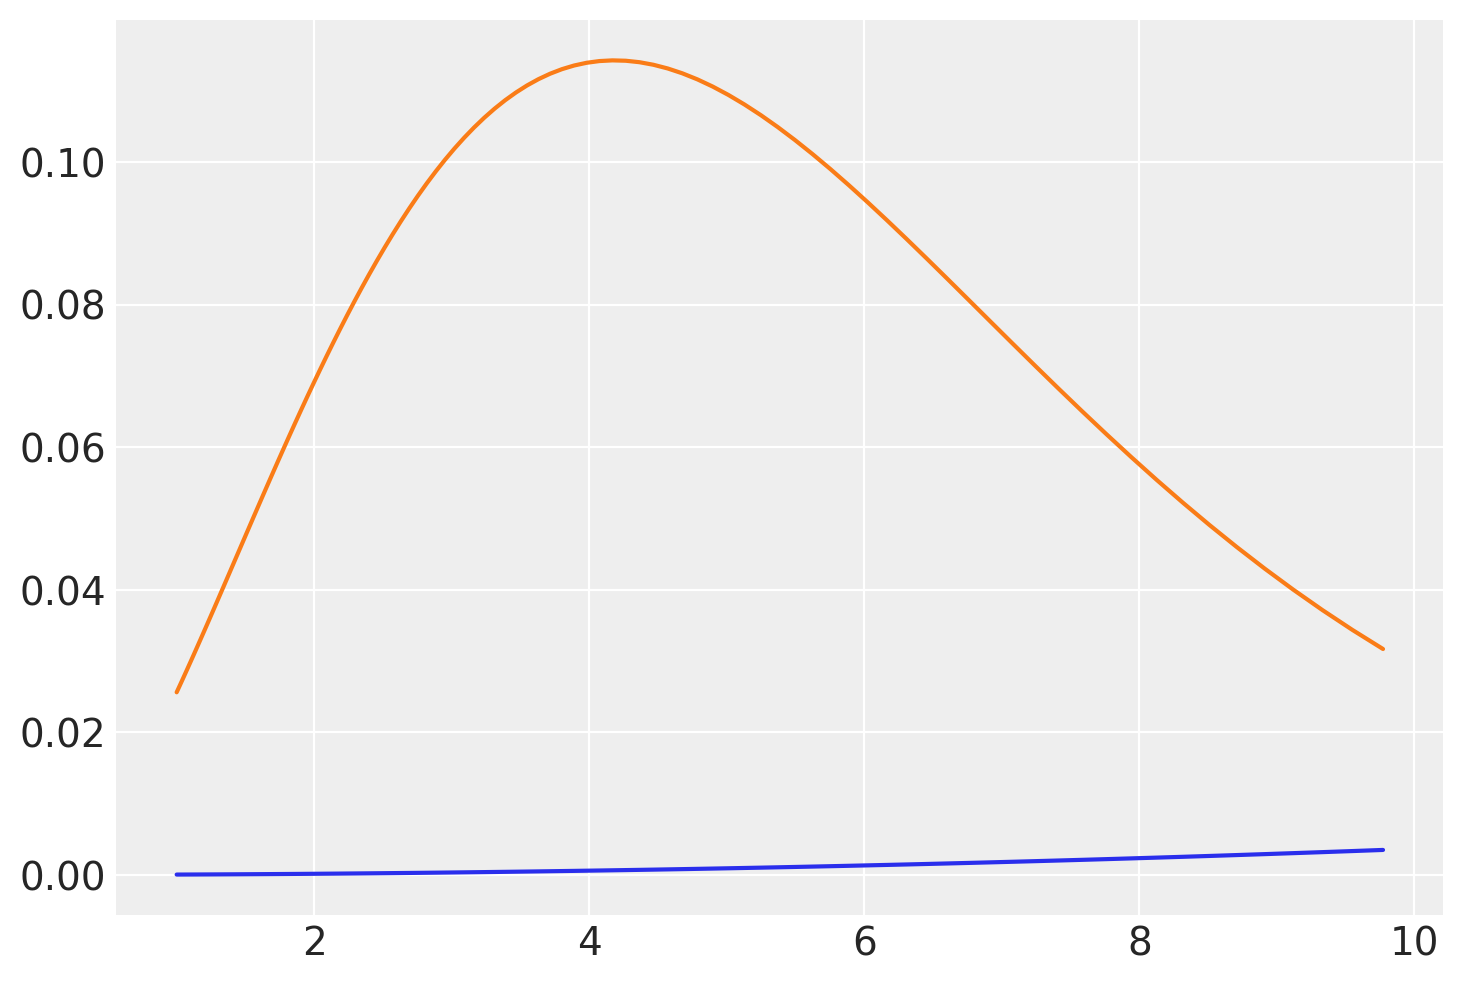

In [92]:
plt.plot(ebins[:-1], bbodyrad(1.5, ebins).eval())
plt.plot(ebins[:-1], _perform(1.5, ebins)*t)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PhoIndex, norm]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.



{'PhoIndex': array(1.7133648), 'norm': array(2.36217049)} <xarray.Dataset>
Dimensions:   (hdi: 2)
Coordinates:
  * hdi       (hdi) <U6 'lower' 'higher'
Data variables:
    PhoIndex  (hdi) float64 1.574 1.862
    norm      (hdi) float64 2.224 2.522


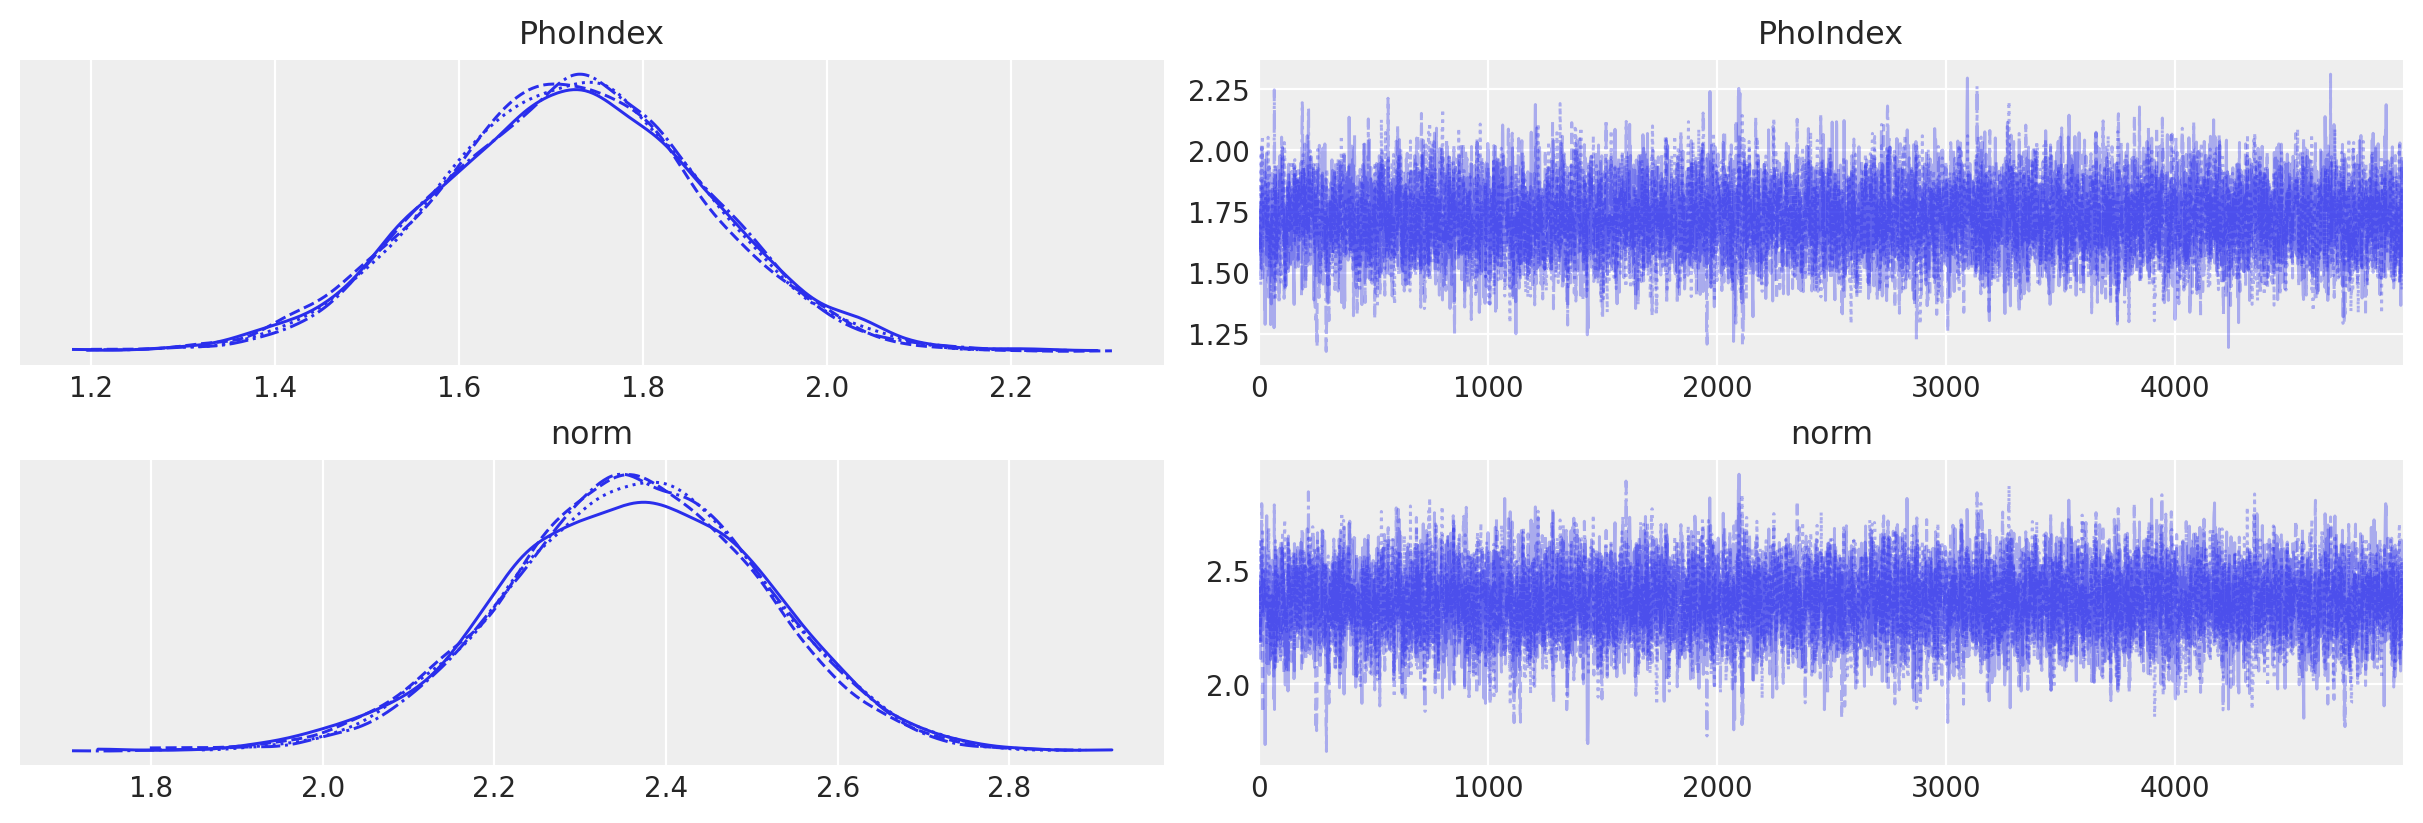

In [185]:
import numpy as np
import pytensor.tensor as pt
from pytensor.gradient import hessian
from pytensor.ifelse import ifelse

class SpectralModel:
    def __call__(self, ebins):
        return self.flux(ebins)

    def __add__(self, other):
        return self._excute_operator('__add__', other)
    def __radd__(self, other):
        return self._excute_operator('__radd__', other)

    def __sub__(self, other):
        return self._excute_operator('__sub__', other)
    def __rsub__(self, other):
        return self._excute_operator('__rsub__', other)

    def __mul__(self, other):
        return self._excute_operator('__mul__', other)
    def __rmul__(self, other):
        return self._excute_operator('__rmul__', other)

    def __matmul__(self, other):
        return self._excute_operator('__matmul__', other)
    def __rmatmul__(self, other):
        return self._excute_operator('__rmatmul__', other)

    def __truediv__(self, other):
        return self._excute_operator('__truediv__', other)
    def __rtruediv__(self, other):
        return self._excute_operator('__rtruediv__', other)

    def __pow__(self, other):
        return self._excute_operator('__pow__', other)
    def __rpow__(self, other):
        return self._excute_operator('__rpow__', other)

    def __neg__(self):
        return self._excute_operator('__neg__', None)

    def __pos__(self):
        return self._excute_operator('__pos__', None)

    def _excute_operator(self, op, other):
        spectral_model = SpectralModel()
        spectral_model.flux = self._operate_flux(op, other)
        return spectral_model

    def _operate_flux(self, op, other):
        if isinstance(other, SpectralModel):
            f = lambda ebins: getattr(self.flux(ebins), op)(other.flux(ebins))
        elif other is not None:
            f = lambda ebins: getattr(self.flux(ebins), op)(other)
        else:
            f = lambda ebins: getattr(self.flux(ebins), op)()

        return f

    def flux(self, ebins):
        raise NotImplementedError

class Powerlaw(SpectralModel):
    def __init__(self, PhoIndex: pt.TensorVariable):
        self._one_minus_PhoIndex = 1.0 - PhoIndex

    def flux(self, ebins: np.ndarray):
        ebins = np.asarray(ebins, dtype=np.float64, order='C')
        ebins_tensor = pt.constant(ebins)
        N = ifelse(
            pt.neq(self._one_minus_PhoIndex, 0.0),
            ebins**self._one_minus_PhoIndex/self._one_minus_PhoIndex,
            pt.log(ebins)
        )
        return N[1:] - N[:-1]

ebins = np.geomspace(1, 10, 101)
t = 10
src_true = (np.exp(2.0)*Powerlaw(1.5))(ebins)*t
data = np.random.poisson(src_true.eval())
with pm.Model() as model:
    PhoIndex = pm.Flat('PhoIndex')
    norm = pt.exp(pm.Flat('norm'))
    pl = norm*Powerlaw(PhoIndex)
    src = pl
    loglike = pm.Poisson('N', mu=(src*t)(ebins), observed=data)
    idata = pm.sample(5000, target_accept=0.95, random_seed=42)
import arviz as az
az.plot_trace(idata)
print(pm.find_MAP(include_transformed=False, model=model), az.hdi(idata,0.683))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PhoIndex, norm]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 29 seconds.



{'PhoIndex': array(1.70962368), 'norm': array(2.36728919), 'pi_J': array(4.32307575)} <xarray.Dataset>
Dimensions:   (hdi: 2)
Coordinates:
  * hdi       (hdi) <U6 'lower' 'higher'
Data variables:
    PhoIndex  (hdi) float64 1.566 1.861
    norm      (hdi) float64 2.214 2.527
    pi_J      (hdi) float64 4.229 4.416


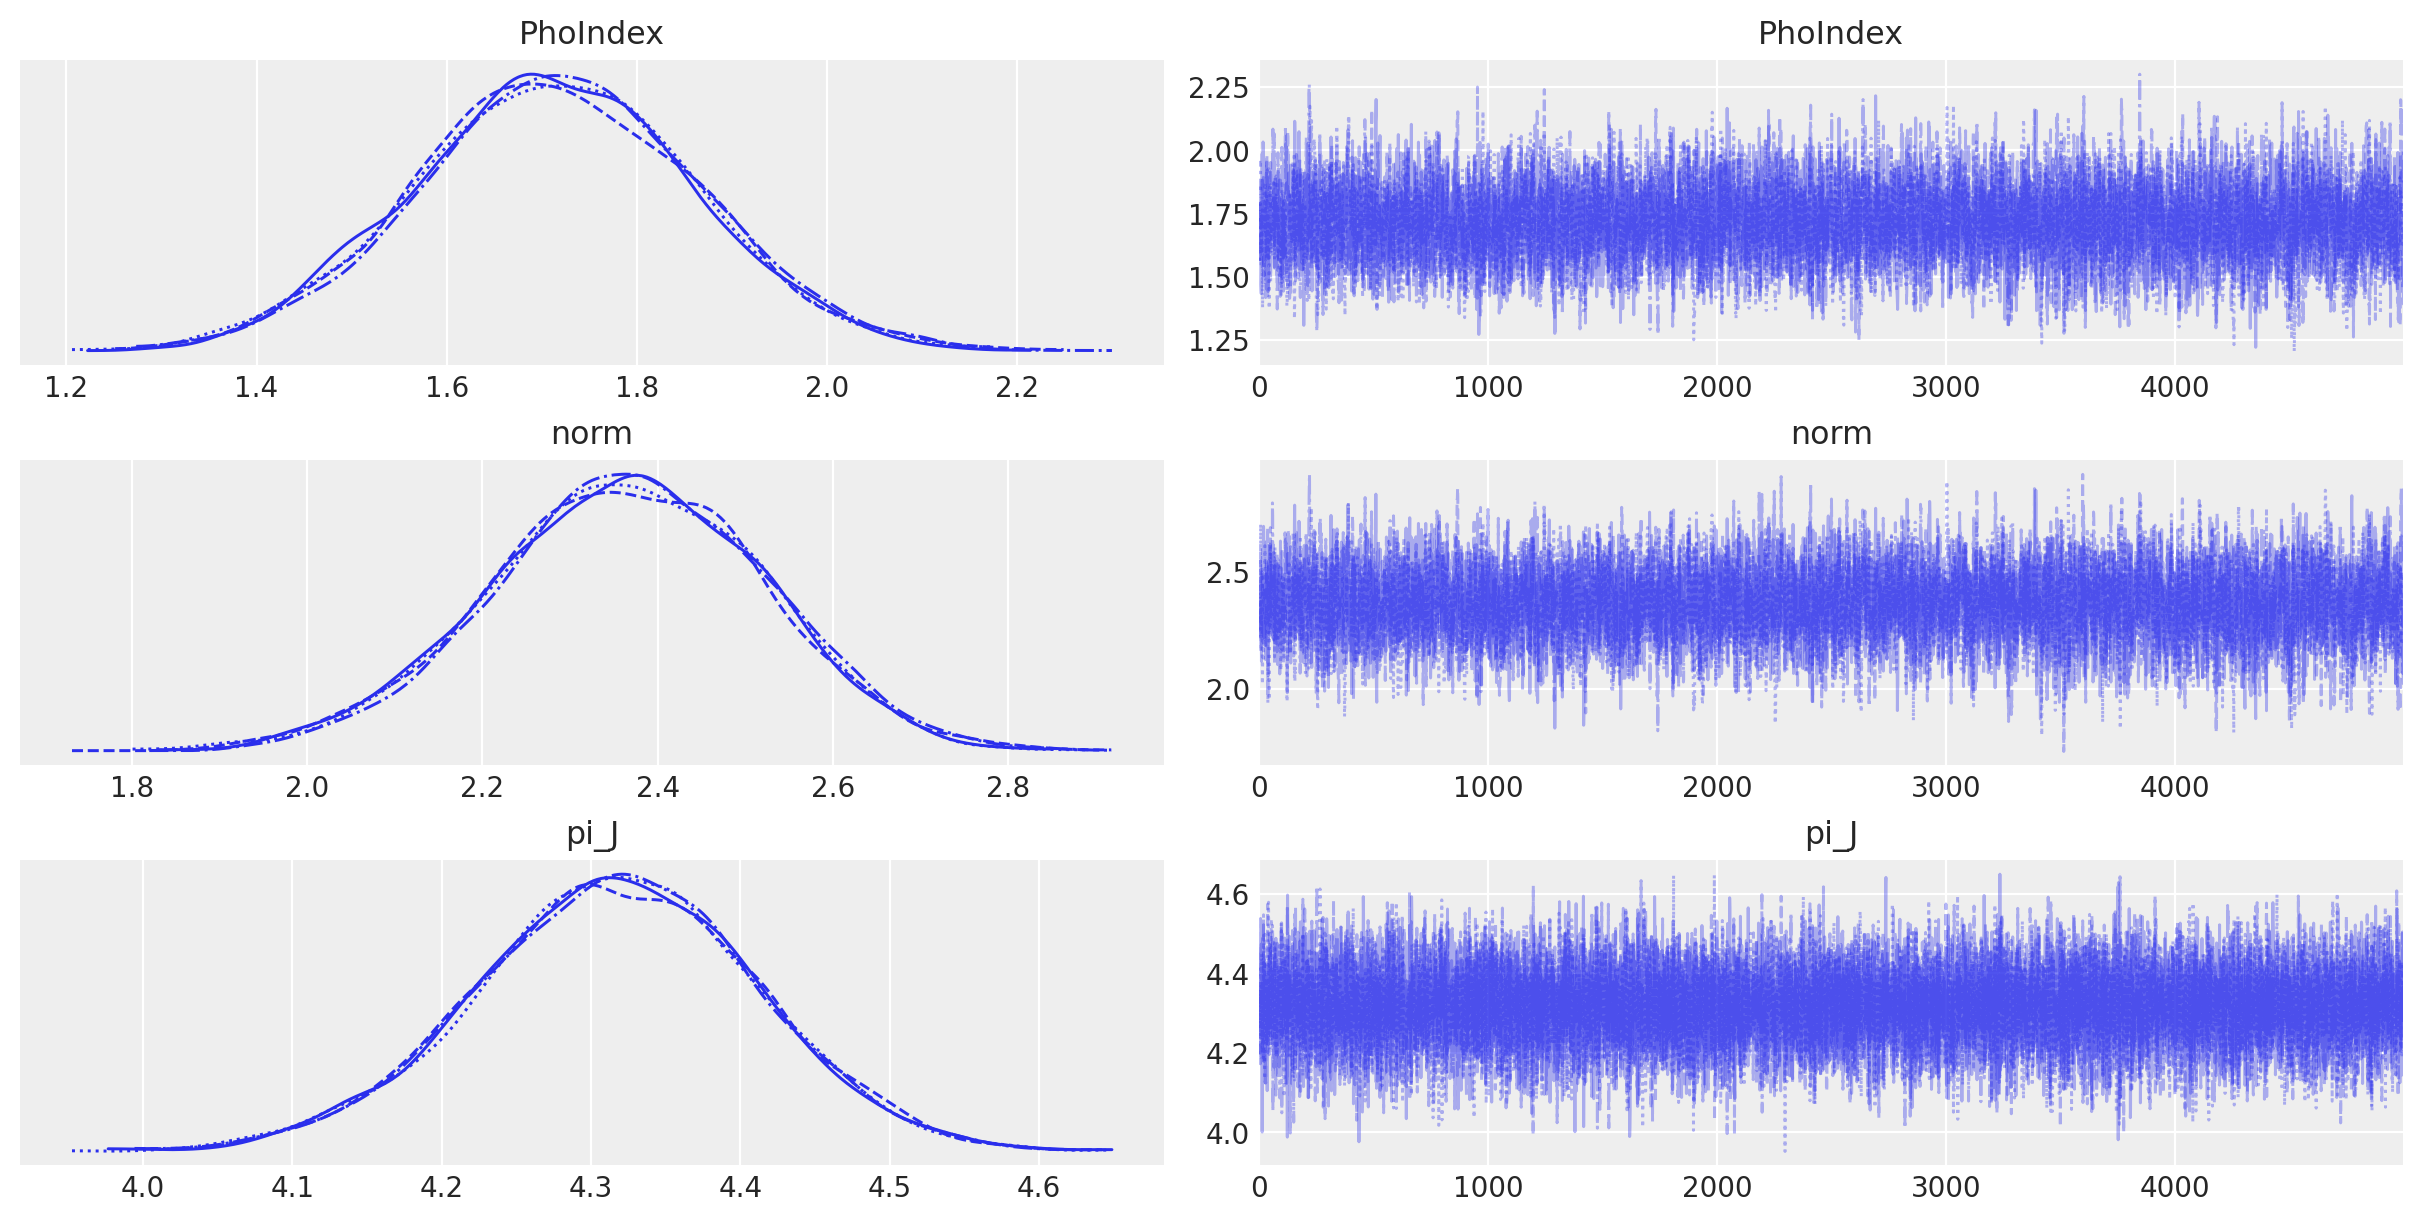

In [186]:
with pm.Model() as model:
    PhoIndex = pm.Flat('PhoIndex')
    norm = pt.exp(pm.Flat('norm'))
    pl = norm*Powerlaw(PhoIndex)
    src = pl
    loglike = pm.Poisson('N', mu=(src*t)(ebins), observed=data)
    pi_J = pt.log(pm.math.det(model.d2logp()))/2.0
    pi_J = pm.Deterministic('prior', pi_J)
    pm.Potential('pi_J', pi_J)

    idata = pm.sample(5000, target_accept=0.95, random_seed=42)
import arviz as az
az.plot_trace(idata)
print(pm.find_MAP(include_transformed=False, model=model), az.hdi(idata,0.683))

[]

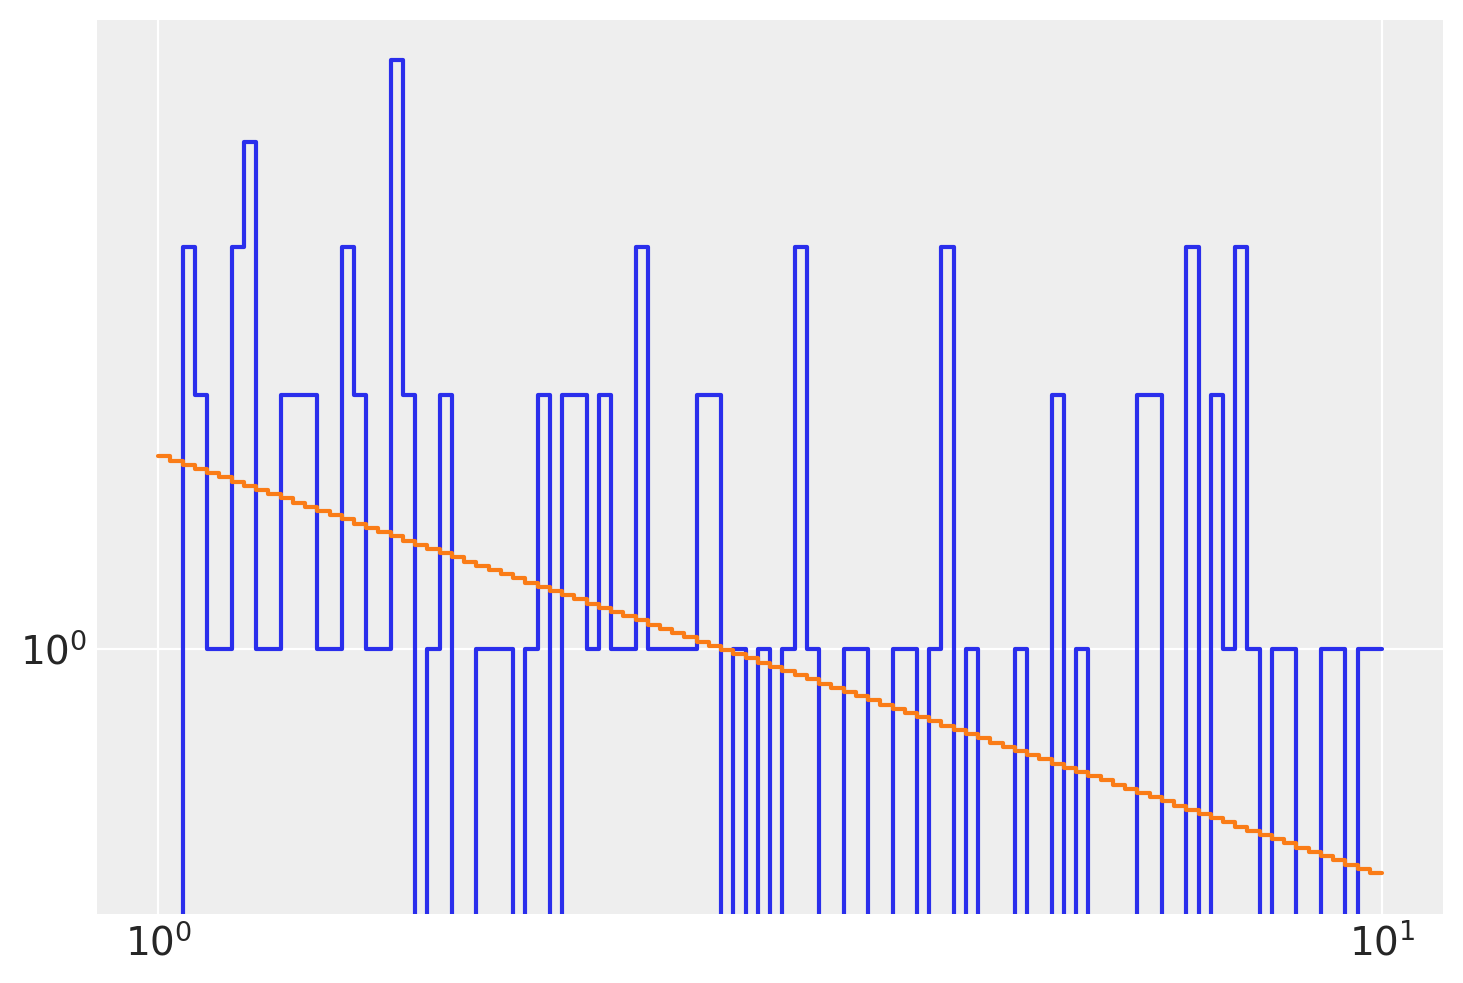

In [181]:
plt.step(ebins, np.append(data, data[-1]), where='post')
plt.step(ebins, np.append(src_true.eval(), src_true.eval()[-1]), where='post')
plt.loglog()